<a href="https://colab.research.google.com/github/eyalgur1/AutoEncoders/blob/main/UNET_optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np


class UNet(nn.Module):
    """
    U-Net Architecture for Image Segmentation.
    This architecture consists of an encoder (contracting path) and a decoder (expanding path)
    with skip connections between corresponding layers to preserve spatial information.
    U-Net requires that the input size is divisible by 2^n, where n is the number of down-sampling layers in the network.
    This ensures the up-sampled feature maps can align with the encoder's feature maps for skip connections.
    """

    def __init__(self, in_channels=3, out_channels=21):  # Set out_channels to the number of classes
        super().__init__()
        """
        Initialize the U-Net model.

        Args:
        - in_channels (int): Number of input channels (e.g., 3 for RGB images).
        - out_channels (int): Number of output channels (e.g., 1 for binary segmentation).
        """
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)  # First convolution block
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Downsample 1
        self.enc2 = self.conv_block(64, 128)  # Second convolution block
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Downsample 2
        self.enc3 = self.conv_block(128, 256)  # Third convolution block
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # Downsample 3
        self.enc4 = self.conv_block(256, 512)  # Fourth convolution block

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsample + reduce channels
        self.dec3 = self.conv_block(512, 256)  # Concatenate + convolution block
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final 1x1 Convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)  # Multi-class output

    def conv_block(self, in_channels, out_channels):
        """
        Double Convolution Block: (Conv2d -> ReLU) * 2
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the U-Net model.
        """

        # Encoder path
        e1 = self.enc1(x)  # [B, 64, 128, 128]
        p1 = self.pool1(e1)  # [B, 64, 64, 64]

        e2 = self.enc2(p1)  # [B, 128, 64, 64]
        p2 = self.pool2(e2)  # [B, 128, 32, 32]

        e3 = self.enc3(p2)  # [B, 256, 32, 32]
        p3 = self.pool3(e3)  # [B, 256, 16, 16]

        e4 = self.enc4(p3)  # [B, 512, 16, 16]

        # Decoder path
        up3 = self.up3(e4)  # Upsample e4 to [B, 256, 32, 32]
        d3 = self.dec3(torch.cat([up3, e3], dim=1))  # Concatenate with e3

        up2 = self.up2(d3)  # Upsample d3 to [B, 128, 64, 64]
        d2 = self.dec2(torch.cat([up2, e2], dim=1))  # Concatenate with e2

        up1 = self.up1(d2)  # Upsample d2 to [B, 64, 128, 128]
        d1 = self.dec1(torch.cat([up1, e1], dim=1))  # Concatenate with e1

        # Final output layer
        out = self.final_conv(d1)  # [B, out_channels, 128, 128]

        return out

    def get_encoder_decoder_params(self):
        """
        Divide the U-Net parameters into encoder and decoder groups.
        This will be used to set up separate optimizers for NAM.

        Returns:
        - encoder_params: Parameters of the encoder.
        - decoder_params: Parameters of the decoder.
        """
        # Collect all parameters from encoder layers
        encoder_params = list(self.enc1.parameters()) + \
                         list(self.enc2.parameters()) + \
                         list(self.enc3.parameters()) + \
                         list(self.enc4.parameters())

        # Collect all parameters from decoder layers, including final output layer
        decoder_params = list(self.dec3.parameters()) + \
                         list(self.dec2.parameters()) + \
                         list(self.dec1.parameters()) + \
                         list(self.up3.parameters()) + \
                         list(self.up2.parameters()) + \
                         list(self.up1.parameters()) + \
                         list(self.final_conv.parameters())

        return encoder_params, decoder_params


# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1e-6):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, outputs, targets):
#         outputs = torch.sigmoid(outputs)  # Convert logits to probabilities
#         # Debugging: Check the range of outputs
#         outputs = outputs.view(-1)  # Flatten
#         targets = targets.view(-1)  # Flatten

#         intersection = (outputs * targets).sum()
#         union = outputs.sum() + targets.sum()

#         dice_coefficient = (2.0 * intersection + self.smooth) / (union + self.smooth)
#         dice_loss = 1 - dice_coefficient

#         return dice_loss


# class DiceBCELoss(nn.Module):
#     def __init__(self, smooth=1e-6):
#         super(DiceBCELoss, self).__init__()
#         self.dice_loss = DiceLoss(smooth)
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def forward(self, outputs, targets):
#         dice = self.dice_loss(outputs, targets)
#         bce = self.bce_loss(outputs, targets)
#         return dice + bce

class MultiClassDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(MultiClassDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets, num_classes):
        """
        Compute Dice Loss for multi-class segmentation.

        Args:
        - outputs: Predicted logits, shape (batch_size, num_classes, height, width).
        - targets: Ground truth masks, shape (batch_size, height, width).
        - num_classes: Number of segmentation classes.

        Returns:
        - Multi-class Dice Loss (averaged over all classes).
        """
        dice_loss = 0.0

        outputs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        for cls in range(num_classes):
            pred_cls = outputs[:, cls, :, :]  # Probability map for class `cls`
            target_cls = (targets == cls).float()  # Binary ground truth for class `cls`

            intersection = (pred_cls * target_cls).sum()
            union = pred_cls.sum() + target_cls.sum()

            dice_loss += 1 - (2.0 * intersection + self.smooth) / (union + self.smooth)

        return dice_loss / num_classes  # Average Dice Loss across all classes


class DiceCELoss(nn.Module):
    def __init__(self, num_classes, class_weights, smooth=1e-6):
        super(DiceCELoss, self).__init__()
        self.num_classes = num_classes
        self.dice_loss = MultiClassDiceLoss(smooth)
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=255)

    def forward(self, outputs, targets):
        """
        Compute combined Dice and CrossEntropy Loss.

        Args:
        - outputs: Predicted logits, shape (batch_size, num_classes, height, width).
        - targets: Ground truth masks, shape (batch_size, height, width).

        Returns:
        - Combined Dice and CrossEntropy Loss.
        """
        dice = self.dice_loss(outputs, targets, self.num_classes)
        ce = self.ce_loss(outputs, targets)
        return dice + ce


def set_seed(seed):
    """
    Set the random seed for reproducibility.
    Args:
    - seed (int): The random seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed(seed)  # For current GPU
    torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disable CuDNN optimization for determinism


In [ ]:
import torch.nn as nn
import torch.optim as optim
import random
import time  # For runtime tracking


def switch_requires_grad(decoder_params, encoder_params, optimize_encoder):  # switch requires_grad for model object containing encoder and decoder
    if optimize_encoder:
        for p in decoder_params:
            p.requires_grad = False
        for p in encoder_params:
            p.requires_grad = True
    else:
        for p in encoder_params:
            p.requires_grad = False
        for p in decoder_params:
            p.requires_grad = True


def train_model(
        model, train_loader, val_loader, num_epochs, device, class_weights,
        optimizer_type="adam", lr_encoder=1e-3, lr_decoder=1e-3, alternating_strategy="epoch"
):
    """
    Generalized training function for U-Net with NAM or standard ADAM optimization.
    Training loss is displayed for each batch, and colors can alternate for NAM models.

    Args:
    - model: The U-Net model.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - num_epochs: Total number of epochs.
    - device: Device (CPU or GPU).
    - optimizer_type: "adam" for standard ADAM or "nam" for NAM optimization.
    - lr_encoder: Learning rate for the encoder (used in NAM).
    - lr_decoder: Learning rate for the decoder (used in NAM).
    - alternating_strategy: Strategy for alternating optimization ("epoch" or "batch").

    Returns:
    - Trained model and training history (loss and IoU).
    """
    # Define loss function
    #criterion = nn.BCEWithLogitsLoss()
    #criterion = DiceBCELoss()
    num_classes = 21  # Define the number of classes based on your dataset
    criterion = DiceCELoss(num_classes=num_classes, class_weights=class_weights)

    # Move the model to the specified device
    model = model.to(device)

    # Track loss and IoU
    history = {'train_loss': [], 'train_optimizer': [], 'val_loss': [], 'val_iou': []}

    # Prepare optimizers
    if optimizer_type == "nam":
        encoder_params, decoder_params = model.get_encoder_decoder_params()
        encoder_optimizer = optim.Adam(encoder_params, lr=lr_encoder)
        decoder_optimizer = optim.Adam(decoder_params, lr=lr_decoder)
        #encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='min', factor=0.1, patience=3)
        #decoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='min', factor=0.1, patience=3)
    elif optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr_encoder)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    model.train()  # Set model to training mode

    # Initialize timers for total training runtime
    total_training_time = 0  # Total time for training across all epochs

    for epoch in range(num_epochs):
        print(f"[{optimizer_type.upper()}] Epoch {epoch + 1}/{num_epochs}")

        epoch_training_start = time.time()  # Start timing the training portion of the epoch

        if optimizer_type == "nam":
            optimize_encoder = not (epoch % 2 == 0) if alternating_strategy == "epoch" else False
            switch_requires_grad(decoder_params, encoder_params, optimize_encoder)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            #masks = masks.long()  # Convert masks to LongTensor
            #assert masks.min() >= 0 and masks.max() < num_classes, f"Target masks have invalid values: min={masks.min()}, max={masks.max()}. Expected range: 0-{num_classes - 1}"  # Check if masks have values in the correct range (0 to num_classes - 1)

            if optimizer_type == "nam":
                # Reset gradients
                if not optimize_encoder:
                    decoder_optimizer.zero_grad()  # clear the gradients of all decoder parameters
                else:
                    encoder_optimizer.zero_grad()  # clear the gradients of all encoder parameters

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()  # calculate partial_L/partial_x for all parameters

                # Backward pass and optimization
                if optimize_encoder:
                    encoder_optimizer.step()
                    optimizer_name = "encoder"
                else:
                    decoder_optimizer.step()
                    optimizer_name = "decoder"

                # Alternate optimizer in batch-wise strategy
                if alternating_strategy == "batch":
                    optimize_encoder = not optimize_encoder
                    switch_requires_grad(decoder_params, encoder_params, optimize_encoder)
            else:
                # Standard ADAM optimization
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                optimizer_name = "adam"

            # Track batch-wise loss and optimizer
            history['train_loss'].append(loss.item())
            history['train_optimizer'].append(optimizer_name)

            # Print batch loss
            print(f"[{optimizer_type.upper()}] Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

        epoch_training_end = time.time()  # End timing the training portion
        epoch_training_time = epoch_training_end - epoch_training_start
        total_training_time += epoch_training_time  # Accumulate total training time

        print(f"Epoch {epoch + 1} training runtime: {epoch_training_time:.2f} seconds")

        # Validation
        val_loss, val_iou = evaluate(model, val_loader, device, criterion)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        print(f"[{optimizer_type.upper()}] Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

        # Adjust learning rate using scheduler
        # if optimizer_type == "nam":
        #     encoder_scheduler.step(val_loss)
        #     decoder_scheduler.step(val_loss)
        # elif optimizer_type == "adam":
        #     scheduler.step(val_loss)

    print(f"Total training runtime (excluding validation): {total_training_time:.2f} seconds")
    print(f"Training complete with {optimizer_type.upper()} optimization.")
    return model, history


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation


class VOCSegmentationCustom(VOCSegmentation):
    # The parent class expects the arguments root, year, image_set, download, and they are passed directly to the child.
    def __init__(self, root, year="2012", image_set="train", download=False, image_size=(128, 128), binary_class=False):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.binary_class = binary_class

        # Define transformations
        self.transform_image = transforms.Compose([
            transforms.Resize(image_size),  # Resize image to fixed size
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.NEAREST),  # Resize mask to fixed size
            transforms.PILToTensor()  # Convert mask to tensor
        ])

    def __getitem__(self, index):
        # Retrieve the image and mask using the parent class's __getitem__ method
        image, mask = super().__getitem__(index)

        image = self.transform_image(image)  # Apply image transformations

        if self.binary_class:
          # Convert mask to binary (foreground/background)
          mask = self.transform_mask(mask)  # Apply mask transformations
          mask = (mask > 0).float()
        else:
          # plt.imshow(np.array(mask), cmap="jet")
          # plt.colorbar()
          # plt.title("Original Mask")
          # plt.show()
          # print("Unique values in the raw mask:", np.unique(np.array(mask)))
          mask = self.transform_mask(mask).squeeze(0).long()  # Resizes the mask to the desired image dimensions using nearest-neighbor interpolation
          # plt.imshow(np.array(mask), cmap="jet")
          # plt.colorbar()
          # plt.title("Transformed Mask")
          # plt.show()
          #print("Unique values in the trans mask:", np.unique(np.array(mask)))
          # Then converts the mask to a tensor of shape (1, height, width).

        return image, mask


def prepare_dataloader(batch_size=8, image_size=(128, 128), download_data=False, binary_class=False, num_classes=21):
    """
    Prepares the Pascal VOC dataset and returns DataLoaders for training and validation.

    Args:
    - batch_size: Number of samples per batch.
    - image_size: Tuple (height, width) for resizing images and masks.
    - binary_class: If True, convert masks to binary with no classes (foreground vs. background).
    - num_classes: Number of segmentation classes.

    Returns:
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - class_weights: Tensor of class weights calculated from the training dataset.
    """
    # Load Pascal VOC dataset (train and validation splits)
    train_dataset = VOCSegmentationCustom(
        root="./data", year="2012", image_set="train", download=download_data, image_size=image_size, binary_class=binary_class
    )
    val_dataset = VOCSegmentationCustom(
        root="./data", year="2012", image_set="val", download=download_data, image_size=image_size, binary_class=binary_class
    )

    # Create DataLoaders
    # The DataLoader iterates over the dataset in batches.
    # For each batch, it calls the dataset’s __getitem__ method for the corresponding indices.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    # num_workers parameter specifies the number of subprocesses (child processes) used for data loading.
    # These child processes work in parallel to load and preprocess batches of data while the main process runs the training loop.

    # Compute class weights based on the training dataset
    class_counts = torch.zeros(num_classes, dtype=torch.long)
    for _, mask in train_loader:  # Iterate over training masks
        for cls in range(num_classes):
            class_counts[cls] += (mask.flatten() == cls).sum().item()

    # Compute weights inversely proportional to class frequency
    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights[class_counts == 0] = 0  # Ensure unused classes have zero weight
    class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1

    return train_loader, val_loader, class_weights


In [ ]:
import torch
import matplotlib.pyplot as plt
import os


def evaluate(model, loader, device, criterion, num_classes=21, ignore_index=255):
    """
    Evaluate the model on a given DataLoader.

    Args:
    - model: The U-Net model.
    - loader: DataLoader (validation or training).
    - device: Device (CPU or GPU).
    - criterion: Loss function.
    - num_classes: Number of segmentation classes.
    - ignore_index: Class index to ignore in IoU calculation.

    Returns:
    - Average loss and mean IoU for the dataset.
    """
    model.eval()  # Ensure the model is in evaluation mode
    running_loss = 0.0
    intersection_per_class = torch.zeros(num_classes, device=device)
    union_per_class = torch.zeros(num_classes, device=device)

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Ignore the pixels with the ignore index
            valid_mask = masks != ignore_index
            #class_counts = torch.bincount(masks.flatten(), minlength=21)
            #print("Class distribution:", class_counts)

            # Forward pass
            outputs = model(images)  # Shape: [batch_size, num_classes, height, width]
            loss = criterion(outputs, masks)

            # Predictions
            #print("Model output logits stats:")
            #print("Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())
            #print("Logits per class (mean over batch):")
            #for cls in range(outputs.shape[1]):  # outputs.shape[1] is num_classes
            #    print(f"Class {cls}: Mean={outputs[:, cls, :, :].mean().item()} Max={outputs[:, cls, :, :].max().item()} Min={outputs[:, cls, :, :].min().item()}")
            predictions = torch.argmax(outputs, dim=1)  # Shape: [batch_size, height, width]
            #print("Unique values in predictions:", torch.unique(predictions))
            #print("Unique values in masks:", torch.unique(masks))

            for cls in range(num_classes):
                # Compute for each class while excluding ignore index
                pred_cls = (predictions == cls) & valid_mask
                mask_cls = (masks == cls) & valid_mask

                intersection = (pred_cls & mask_cls).sum().float()  # Intersection for class `cls`
                union = (pred_cls | mask_cls).sum().float()  # Union for class `cls`

                intersection_per_class[cls] += intersection
                union_per_class[cls] += union

            running_loss += loss.item()

    # Compute mean IoU
    iou_per_class = intersection_per_class / (union_per_class + 1e-6)
    mean_iou = iou_per_class[union_per_class > 0].mean().item()  # Only include valid classes

    avg_loss = running_loss / len(loader)
    return avg_loss, mean_iou


def plot_training_and_validation(history_nam, history_adam, output_dir="./results"):
    """
    Plot training loss, validation loss, and validation IoU for NAM and ADAM on the same figure.

    Args:
    - history_nam: Training history dictionary for NAM optimizer, containing 'train_loss', 'val_loss', and 'val_iou'.
    - history_adam: Training history dictionary for ADAM optimizer, containing 'train_loss', 'val_loss', and 'val_iou'.
    - output_dir: Directory to save the figures.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    plt.figure(figsize=(15, 10))

    # Plot training loss
    plt.subplot(2, 1, 1)

    # NAM training loss with seamless line connections
    colors = {'encoder': 'blue', 'decoder': 'green'}
    current_segment_start = 0  # Start of the current segment
    for i in range(1, len(history_nam['train_loss'])):
        # Check for optimizer switch
        if history_nam['train_optimizer'][i] != history_nam['train_optimizer'][i - 1]:
            # Plot the current segment, including the first point of the next segment
            plt.plot(
                range(current_segment_start, i + 1),
                history_nam['train_loss'][current_segment_start:i + 1],
                color=colors[history_nam['train_optimizer'][i - 1]],
                linestyle='-',
                label=f"{history_nam['train_optimizer'][i - 1].capitalize()} Loss (NAM)" if current_segment_start == 0 else None
            )
            current_segment_start = i  # Start a new segment
    # Plot the final segment
    plt.plot(
        range(current_segment_start, len(history_nam['train_loss'])),
        history_nam['train_loss'][current_segment_start:],
        color=colors[history_nam['train_optimizer'][-1]],
        linestyle='-',
        label=f"{history_nam['train_optimizer'][-1].capitalize()} Loss (NAM)" if current_segment_start == 0 else None
    )

    # ADAM training loss
    plt.plot(
        range(len(history_adam['train_loss'])),
        history_adam['train_loss'],
        label="Training Loss (ADAM)",
        color='red',
        linestyle='-'
    )

    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Training Loss (NAM vs. ADAM)")
    plt.legend()

    # Plot validation loss and IoU
    plt.subplot(2, 1, 2)
    epochs_nam = range(1, len(history_nam['val_loss']) + 1)
    epochs_adam = range(1, len(history_adam['val_loss']) + 1)

    # NAM validation metrics
    plt.plot(epochs_nam, history_nam['val_loss'], label="Validation Loss (NAM)", color='orange', linestyle='-')
    plt.plot(epochs_nam, history_nam['val_iou'], label="Validation IoU (NAM)", color='purple', linestyle='-')

    # ADAM validation metrics
    plt.plot(epochs_adam, history_adam['val_loss'], label="Validation Loss (ADAM)", color='brown', linestyle='--')
    plt.plot(epochs_adam, history_adam['val_iou'], label="Validation IoU (ADAM)", color='pink', linestyle='--')

    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Validation Loss and IoU (NAM vs. ADAM)")
    plt.legend()

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "NAM_vs_ADAM_metrics.png"))
    plt.show()


def count_trainable_params(params):
    """
    Count the number of trainable parameters in a list of parameters.
    """
    return sum(p.numel() for p in params) # Includes non-trainable paramters, otherwise set `if p.required_grad`


Preparing DataLoaders...

Initial weights are identical for both models!

Training with NAM Optimization...
[NAM] Epoch 1/10
[NAM] Batch 1, Loss: 4.0086
[NAM] Batch 2, Loss: 4.0025
[NAM] Batch 3, Loss: 4.0168
[NAM] Batch 4, Loss: 4.0354
[NAM] Batch 5, Loss: 4.0947
[NAM] Batch 6, Loss: 3.9972
[NAM] Batch 7, Loss: 4.0340
[NAM] Batch 8, Loss: 4.0302
[NAM] Batch 9, Loss: 4.0401
[NAM] Batch 10, Loss: 4.0737
[NAM] Batch 11, Loss: 3.9865
[NAM] Batch 12, Loss: 4.0351
[NAM] Batch 13, Loss: 4.0219
[NAM] Batch 14, Loss: 4.0410
[NAM] Batch 15, Loss: 4.0272
[NAM] Batch 16, Loss: 4.0411
[NAM] Batch 17, Loss: 4.0262
[NAM] Batch 18, Loss: 4.0526
[NAM] Batch 19, Loss: 4.0246
[NAM] Batch 20, Loss: 4.0509
[NAM] Batch 21, Loss: 4.0386
[NAM] Batch 22, Loss: 4.0467
[NAM] Batch 23, Loss: 4.0316
[NAM] Batch 24, Loss: 4.0316
[NAM] Batch 25, Loss: 4.0327
[NAM] Batch 26, Loss: 4.0269
[NAM] Batch 27, Loss: 4.0230
[NAM] Batch 28, Loss: 4.0152
[NAM] Batch 29, Loss: 4.0170
[NAM] Batch 30, Loss: 4.0384
[NAM] Batch 31

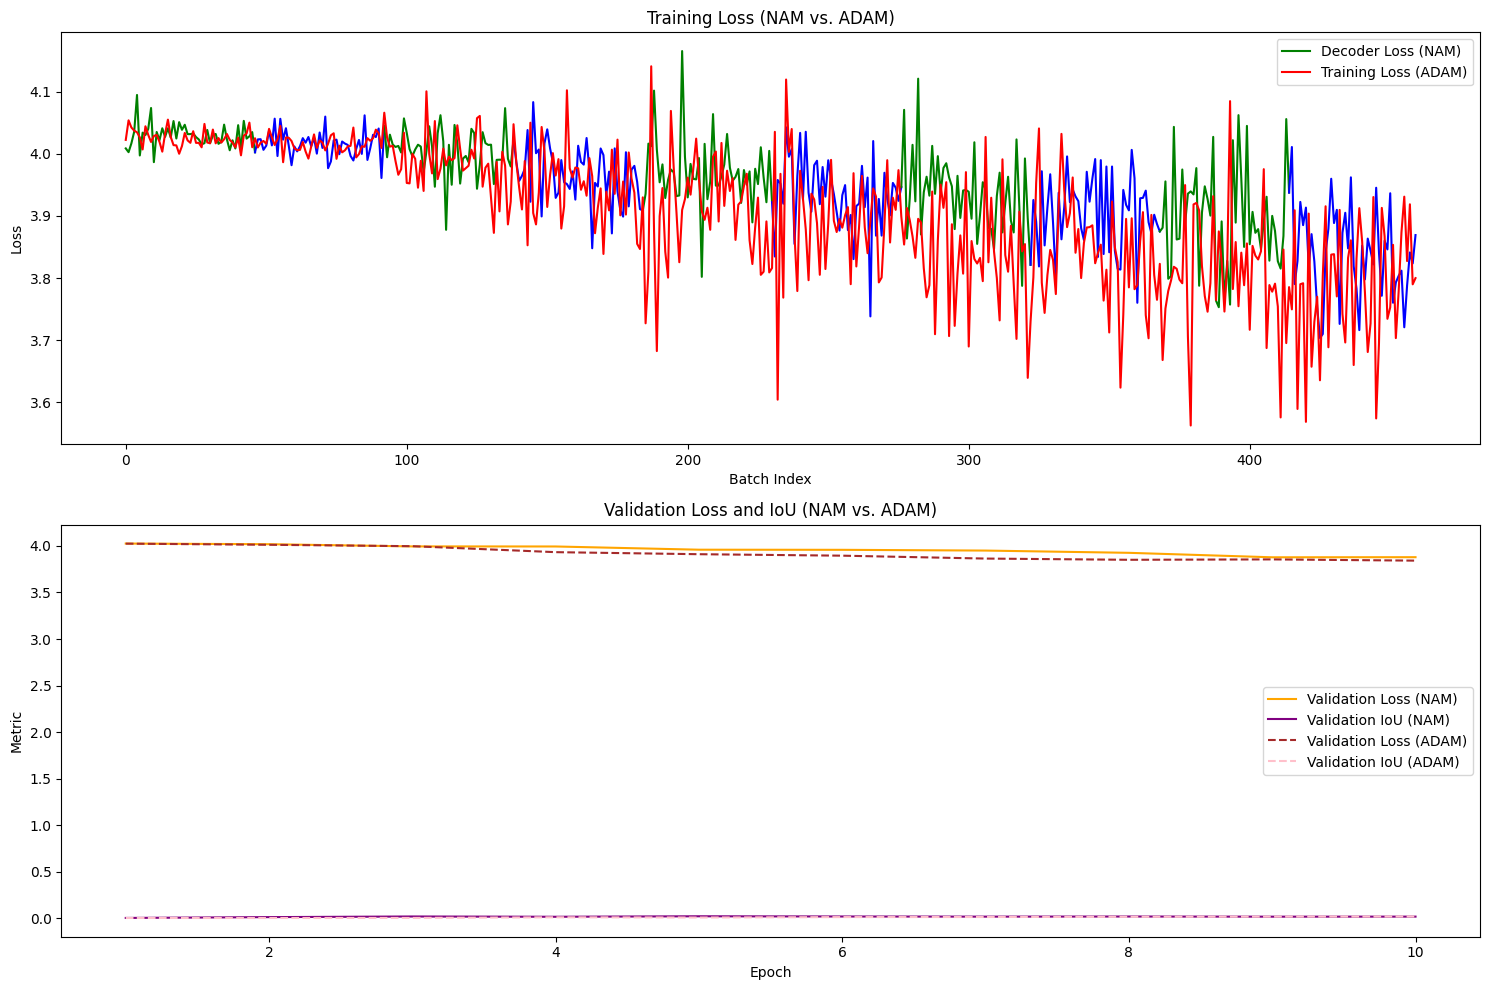


Final Validation Results:
NAM Optimization - Final Validation Loss: 3.8789, Final Validation IoU: 0.0190
ADAM Optimization - Final Validation Loss: 3.8418, Final Validation IoU: 0.0201
Total trainable parameters (ADAM): 7698645
Trainable parameters (NAM Encoder): 4685376
Trainable parameters (NAM Decoder): 3013269


In [ ]:
import torch


if __name__ == '__main__':
    """
    The main process runs the training script and uses child processes to load batches of data in parallel.
    These child processes are created when you set num_workers > 0 in the DataLoader.
    When we use multiprocessing (e.g., via PyTorch’s DataLoader with num_workers > 0),
    Python needs to spawn child processes. On Windows, these child processes start fresh Python interpreters,
    which then re-import the script to know what code to execute. Hence, without the if __name__ == '__main__': guard,
    the script is re-imported in the new interpreter started by multiprocessing Everything in the script is executed
    again (including the code to start more processes), causing a loop or error.
    """
    # Hyperparameters
    num_epochs = 10
    batch_size = 32
    image_size = (128, 128)
    download_data = False
    binary_class = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lr_encoder = 1e-4  # Learning rate for encoder
    lr_decoder = 1e-3  # Learning rate for decoder
    lr_adam = 1e-4
    seed = 42

    # Prepare DataLoaders
    print("Preparing DataLoaders...")
    train_loader, val_loader, class_weights = prepare_dataloader(
        batch_size=batch_size, image_size=image_size,  download_data=download_data, binary_class=binary_class)
    #print(class_weights)

    # Instantiate NAM Model
    #set_seed(seed)  # Setting the seed before defining the model
    model_nam = UNet(in_channels=3, out_channels=21)

    # Instantiate ADAM Model
    #set_seed(seed)  # Setting the seed before defining the model
    model_adam = UNet(in_channels=3, out_channels=21)

    # Verify that the weights are identical
    #for p1, p2 in zip(model_nam.parameters(), model_adam.parameters()):
    #    assert torch.equal(p1, p2), "Initial weights are not the same!"
    #print("\nInitial weights are identical for both models!")

    #print("\nPrinting UNet Model Architecture...")
    #print(model_adam)  # Print the architecture to verify its structure (the same architecture for both)

    # Save initial weights from model_adam
    initial_weights = model_adam.state_dict()

    # Reset weights for model_nam
    model_nam.load_state_dict(initial_weights)

    for p1, p2 in zip(model_nam.parameters(), model_adam.parameters()):
        assert torch.equal(p1, p2), "Initial weights are not the same!"
    print("\nInitial weights are identical for both models!")

    # Train NAM Optimization
    print("\nTraining with NAM Optimization...")
    trained_model_nam, nam_history = train_model(
        model_nam, train_loader, val_loader, num_epochs, device, class_weights,
        optimizer_type="nam", lr_encoder=lr_encoder, lr_decoder=lr_decoder, alternating_strategy="epoch",
    )

    # Train Standard ADAM Optimization
    print("\nTraining with Standard ADAM Optimization...")
    trained_model_adam, adam_history = train_model(
        model_adam, train_loader, val_loader, num_epochs, device, class_weights,
        optimizer_type="adam", lr_encoder=lr_adam,
    )

    # Plot Results
    print("\nPlotting Results for NAM and ADAN Optimization...")
    plot_training_and_validation(nam_history, adam_history)

    # Print Final Results
    print("\nFinal Validation Results:")
    print(f"NAM Optimization - Final Validation Loss: {nam_history['val_loss'][-1]:.4f}, Final Validation IoU: {nam_history['val_iou'][-1]:.4f}")
    print(f"ADAM Optimization - Final Validation Loss: {adam_history['val_loss'][-1]:.4f}, Final Validation IoU: {adam_history['val_iou'][-1]:.4f}")

    # ADAM: Total number of trainable parameters
    adam_total_params = count_trainable_params(model_adam.parameters())
    print(f"Total trainable parameters (ADAM): {adam_total_params}")

    # NAM: Trainable parameters for encoder and decoder
    encoder_params, decoder_params = model_nam.get_encoder_decoder_params()
    encoder_trainable_params = count_trainable_params(encoder_params)
    decoder_trainable_params = count_trainable_params(decoder_params)

    print(f"Trainable parameters (NAM Encoder): {encoder_trainable_params}")
    print(f"Trainable parameters (NAM Decoder): {decoder_trainable_params}")


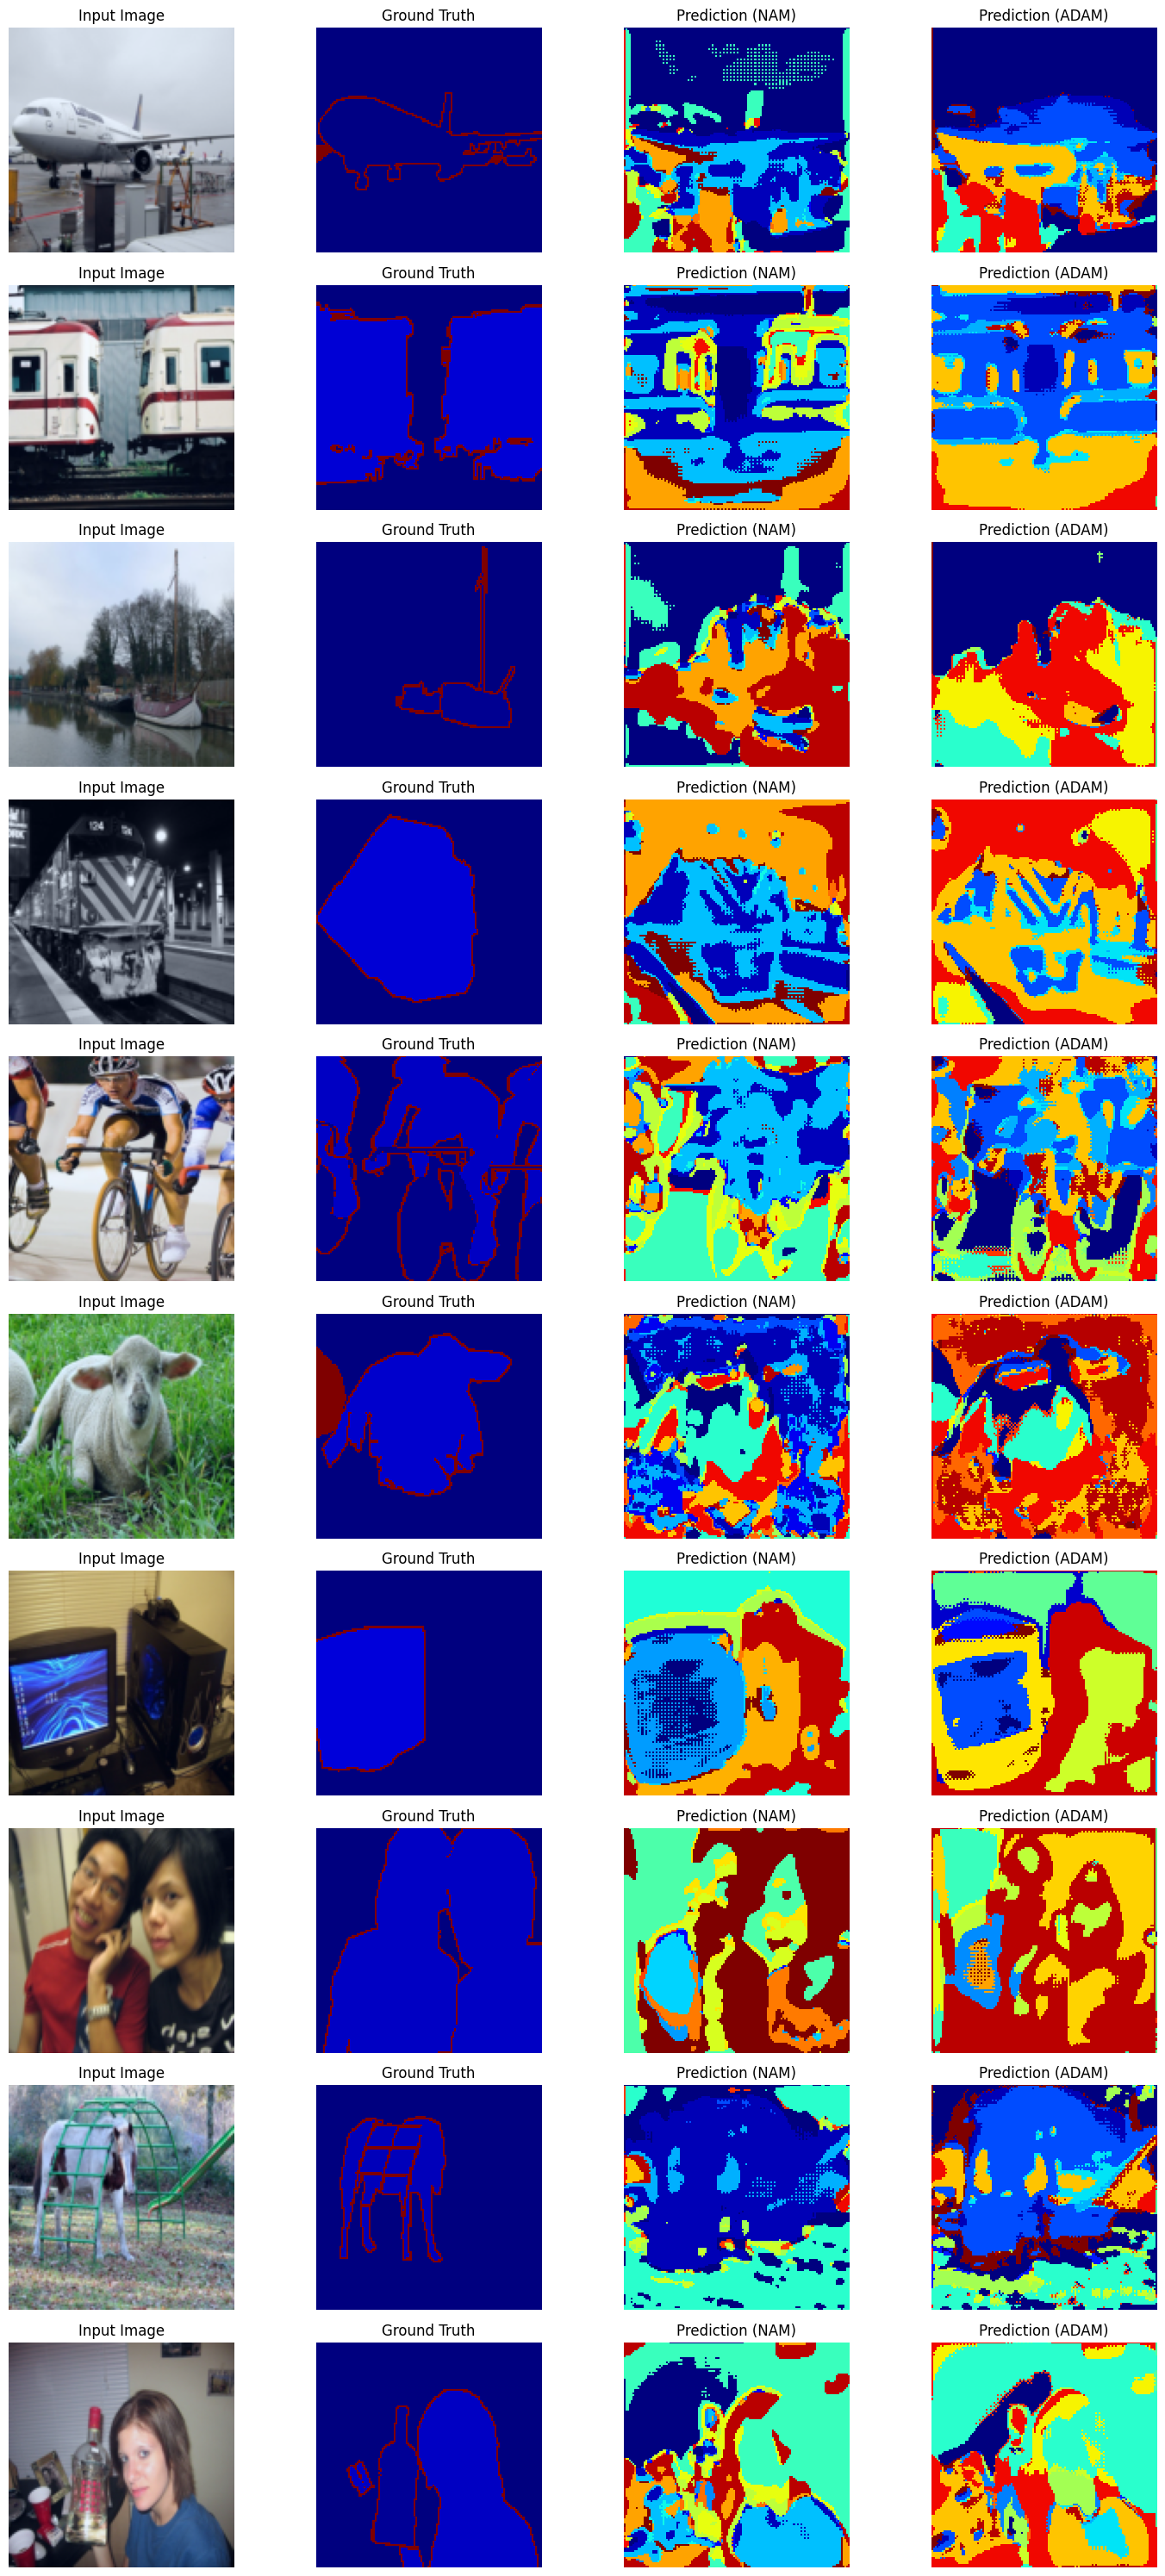

In [ ]:
#import matplotlib.pyplot as plt
import torch

import os
import matplotlib.pyplot as plt
import torch

def visualize_segmentation(models, val_loader, device, output_dir="./results", num_images=10):
    """
    Visualize segmentation results for a few validation images.

    Args:
    - models: Dictionary containing trained models (e.g., {'NAM': model_nam, 'ADAM': model_adam}).
    - val_loader: DataLoader for the validation dataset.
    - device: Device (CPU or GPU) to run the inference.
    - output_dir: Directory to save the visualizations.
    - num_images: Number of images to visualize.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    # Set models to evaluation mode
    for model in models.values():
        model.eval()

    # Fetch a subset of images from the validation set
    val_iter = iter(val_loader)
    images, masks = next(val_iter)
    images, masks = images[:num_images].to(device), masks[:num_images].to(device)

    # Run inference with each model
    predictions = {}
    with torch.no_grad():
        for name, model in models.items():
            outputs = model(images)
            # Get the predicted class for each pixel using argmax
            #print("Model output logits stats:")
            #print("Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())
            preds = torch.argmax(outputs, dim=1)  # Get predicted masks # This line defines 'preds'
            predictions[name] = preds  # Store the predicted masks

    # Visualize images, ground truths, and predictions
    num_cols = len(models) + 2
    fig, axes = plt.subplots(num_images, num_cols, figsize=(15, num_images * 3))
    model_names = list(models.keys())

    for idx in range(num_images):
        # Input image
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis("off")

        # Ground truth
        axes[idx, 1].imshow(masks[idx].cpu().numpy(), cmap="jet", interpolation="nearest")
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        # Predictions from each model
        for j, model_name in enumerate(model_names):
            axes[idx, j + 2].imshow(predictions[model_name][idx].cpu().numpy(), cmap="jet", interpolation="nearest")
            axes[idx, j + 2].set_title(f"Prediction ({model_name})")
            axes[idx, j + 2].axis("off")

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "validation_segmentation_comparison.png"))
    plt.show()



# Call the function with trained models
visualize_segmentation(
    models={'NAM': model_nam, 'ADAM': model_adam},
    val_loader=val_loader,
    device=device,
    output_dir="./results",
    num_images=10
)